In [1]:
# Import the necessary libraries
import h5py
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sknetwork.clustering import Louvain
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics.cluster import v_measure_score, silhouette_score
from scipy import sparse

In [2]:
# Import the respective Datasets
pge_path = './colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = './colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = './colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = './colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

In [3]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [4]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [5]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
labels = np.array([x.decode("utf-8").split('/')[2] for x in filename])

In [6]:
# KMeans(), GaussianMixture(), AgglomerativeClustering(), Louvain() Implementation

In [7]:
# Please indicate the maximum number of clusters for the iterations of KMeans, GaussianMixture & AgglomerativeClustering
N_CLUSTERS = 30

# Below we constructed a function that performs the clustering for each method, as well as for each dataset

In [8]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)


# Main Function
def iterative_clustering(algorithm, max_n_clusters, features, labels, rep, dim_red, show=True):
    
    # Present error when the methods below are not called as input to the funtion 
    assert algorithm in ("KMeans", "GMM", "Hierarchical", "Louvain")
     
    # Print the main initial information for the respective method and dataset  
    print(f"-Clustering Algorithm:                {algorithm}")
    print(f"-Representations:                     {rep}")
    print(f"-Dimensionality Reduction Method:     {dim_red}")
    
    rows = []
    
    # Perform KMeans, GMM and Hierarchical Clustering when the respective input is given
    if algorithm != "Louvain":
        
        # Initialize the necessary values for the resulting illustrations
        column_labels = ["n_clusters", "silhouette score", "v_measure score"]
        
        # Iterate through the selected number of clusters
        for n_clusters in range(2, max_n_clusters):

            if algorithm == "KMeans":
                model = KMeans(n_clusters=n_clusters, random_state = 0)
            elif algorithm == "GMM":
                model = GaussianMixture(n_components=n_clusters, random_state=0)
            elif algorithm == "Hierarchical":
                model = AgglomerativeClustering(n_clusters=n_clusters)
                # Create a Dendrogram as an additional method for finding the optimal number of clusters
                dend = hc.dendrogram(hc.linkage(features, method='ward'))

            # Fit the respective model and get the Silhouette and V_Measure scores
            preds = model.fit_predict(features)
            silhouette = float("{0:.4f}".format(silhouette_score(features, preds)))
            v_measure = float("{0:.4f}".format(v_measure_score(labels, preds)))
            # Store the results into a DataFrame in order to visualize and manipulate them with Pandas
            rows.append((n_clusters, silhouette, v_measure))
            results_df = pd.DataFrame(rows, columns = column_labels)
            
    # Otherwise perform the Louvain Clustering accordingly
    else:
        # Iterate through the different parameters of Louvain, with a view to find the optimal combination 
        # with regards to the measures of fit that we are using
        column_labels = ["n_clusters", "resolution", "modularity", "silhouette score", "v_measure score"]
        resolutions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.9995, 0.99995, 1.0]
        modularities = ['dugue', 'newman', 'potts']
        # Transform the data for the Louvain
        features = MinMaxScaler().fit_transform(-pairwise_distances(features))
        adj_mat = sparse.csr_matrix(features)
        for resolution in resolutions:
            for modularity in modularities:
                # Initialize the model and fit it with the data
                model = Louvain(resolution=resolution, modularity=modularity, random_state=0)
                preds = model.fit_transform(adj_mat)
                # Get the respective number of clusters
                n_clusters = np.unique(preds).shape[0]
                # Condition of >1 number of clusters in order to calculate the measures of fit
                if n_clusters > 1:
                    silhouette = float("{0:.4f}".format(silhouette_score(features, preds)))
                    v_measure = float("{0:.4f}".format(v_measure_score(labels, preds)))
                    # Again store the results into a DataFrame in order to visualize and manipulate them with Pandas
                    rows.append((n_clusters, resolution, modularity, silhouette, v_measure))
                    results_df = pd.DataFrame(rows, columns = column_labels)
                
    # Create 2 additional columns with respect to the calculated measures of fit
    silhouettes = results_df["silhouette score"].to_numpy()
    v_measures = results_df["v_measure score"].to_numpy()
    
    # In this part we display the outputs of the abovementioned calculations with a view to get the "best" of each 
    # measures of fit that we are using
    display(results_df.astype(str).style.hide_index().set_properties(**{'text-align': 'center'}))
    
    # Visualize the results of KMeans, GMM and Hierarchical Clustering when the respective input is given
    if algorithm != "Louvain":
        if show:
            # Create the visual representation fo the Silhouette & V_measure Scores Evolution through the number of clusters
            # Optional: add figsize
            plt.figure()
            plt.plot(np.arange(2, max_n_clusters, 1), silhouettes, label = "Silhouette")
            plt.plot(np.arange(2, max_n_clusters, 1), v_measures, label = "V-measure")
            plt.title("Silhouette & V_measure Scores Evolution", fontsize=15)
            plt.suptitle(f"\n{algorithm} Clustering on {rep} Representations using {dim_red} dimensionality reduction method", y=1.10,)
            plt.xlabel("Number of Clusters")
            plt.ylabel("Score")
            plt.legend(loc=0)
            plt.grid()
            plt.show()
        
        # Get the maximum index and values of the respective measures of fit
        max_silhouette_n_clusters, max_silhouette = np.argmax(silhouettes) + 2, max(silhouettes)
        max_v_measure_n_clusters, max_v_measure = np.argmax(v_measures) + 2, max(v_measures)

        # Print the "optimal" number of clusters with respect to the abovementioned maximum values
        print("Optimal Number of Clusters with reference to Silhouette Score is K=" + str(max_silhouette_n_clusters),
             "with Silhouette Score = " + str(max_silhouette))
        print("Optimal Number of Clusters with reference to V_measure Score is K=" + str(max_v_measure_n_clusters),
             "with V_measure Score = " + str(max_v_measure))
        
        ############################################## Silhouette ####################################################
        
        # Re-calculate our models regarding the extracted "optimal" number of clusters
        if algorithm == "KMeans":
            model_s = KMeans(n_clusters=max_silhouette_n_clusters, random_state = 0)
        elif algorithm == "GMM":
            model_s = GaussianMixture(n_components=max_silhouette_n_clusters, random_state=0)
        elif algorithm == "Hierarchical":
            model_s = AgglomerativeClustering(n_clusters=max_silhouette_n_clusters)
        
        # Fit the respective model
        preds_s = model_s.fit_predict(features)
        
        # Get the number of obseravtions that are attributed to each cluster
        counts_s = np.unique(preds_s, return_counts = True)
        
        # Present the respective table of the counts
        print('\n')
        print(f'{algorithm} assignment counts - Silhouette')
        display(pd.DataFrame({'Cluster Index': counts_s[0], 'Number of members':counts_s[1]}).set_index('Cluster Index'))
        
        # Create a 100% stacked bar chart in order to visually represent the content of the clusters
        resulted_cluster_df = pd.DataFrame({'clusterID': preds_s, 'type': labels})
        label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
        pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

        f, axes = plt.subplots(1, 2, figsize=(15,5))
        axes = axes.ravel()
        number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
        df_idx = pivoted_label_proportion_df.index
        (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

        axes[0].set_ylabel('Percentage of tissue type')
        axes[0].legend(loc='upper right')
        axes[0].set_title(f'Cluster configuration by {algorithm} - Silhouette')
        
        ############################################## V_Measure ####################################################
        
        # Re-calculate our models regarding the extracted "optimal" number of clusters
        if algorithm == "KMeans":
            model_v = KMeans(n_clusters=max_v_measure_n_clusters, random_state = 0)
        elif algorithm == "GMM":
            model_v = GaussianMixture(n_components=max_v_measure_n_clusters, random_state=0)
        elif algorithm == "Hierarchical":
            model_v = AgglomerativeClustering(n_clusters=max_v_measure_n_clusters)
            
        # Fit the respective model
        preds_v = model_v.fit_predict(features)
        
        # Get the number of obseravtions that are attributed to each cluster
        counts_v = np.unique(preds_v, return_counts = True)    
        
        # Present the respective table of the counts
        print('\n')
        print(f'{algorithm} assignment counts - V_measure')
        display(pd.DataFrame({'Cluster Index': counts_v[0], 'Number of members':counts_v[1]}).set_index('Cluster Index'))
          
        # Create a 100% stacked bar chart in order to visually represent the content of the clusters
        resulted_cluster_df = pd.DataFrame({'clusterID': preds_v, 'type': labels})
        label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
        pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

        number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
        df_idx = pivoted_label_proportion_df.index
        (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

        axes[1].set_ylabel('Percentage of tissue type')
        axes[1].legend(loc='upper right')
        axes[1].set_title(f'Cluster configuration by {algorithm} - V_measure')
                
    # Otherwise visualize the results of Louvain Clustering accordingly   
    else:
        
        # Get the maximum values of the Clusters, Resolution and Modularity with respect to silhouette score
        argmax_silhouette, max_silhouette = np.argmax(silhouettes), max(silhouettes)
        max_silhouette_n_clusters, max_silhouette_resolution, max_silhouette_modularity,_ ,_ = results_df.loc[argmax_silhouette]
        # Get the maximum values of the Clusters, Resolution and Modularit with respect to v_measure score
        argmax_v_measure, max_v_measure = np.argmax(v_measures), max(v_measures)
        max_v_measure_n_clusters, max_v_measure_resolution, max_v_measure_modularity,_ , _ = results_df.loc[argmax_v_measure]
        
        # Print the "optimal" number of clusters, resolution and modularity with respect to the abovementioned maximum values
        print("Optimal Number of Clusters with reference to Silhouette Score is K=" + str(max_silhouette_n_clusters),
             "with Silhouette Score = " + str(max_silhouette),
             "\n(given by resolution=" + str(max_silhouette_resolution) + " and " + max_silhouette_modularity.capitalize() + " modularity)")
        print("Optimal Number of Clusters with reference to V_measure Score is K=" + str(max_v_measure_n_clusters),
             "with V_measure Score = " + str(max_v_measure),
             "\n(given by resolution=" + str(max_v_measure_resolution) + " and " + max_v_measure_modularity.capitalize() + " modularity)")
        
        
        ############################################ Silhouette ######################################################
        # Train and fit the model with respect to the optimal parameters indicated by the Silhouette
        model_s = Louvain(resolution=max_silhouette_resolution, modularity=max_silhouette_modularity.capitalize(), random_state=0)
        # Fit the model
        preds_s = model_s.fit_transform(adj_mat)

        # Get the number of obseravtions that are attributed to each cluster
        counts_s = np.unique(preds_s, return_counts = True)

        # Display the respective counts
        print('\n')
        print(f'{algorithm} assignment counts - Silhouette')
        display(pd.DataFrame({'Cluster Index': counts_s[0], 'Number of members':counts_s[1]}).set_index('Cluster Index'))

        # Create a 100% stacked bar chart in order to visually represent the content of the clusters
        resulted_cluster_df = pd.DataFrame({'clusterID': preds_s, 'type': labels})
        label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
        pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

        f, axes = plt.subplots(1, 2, figsize=(15,5))
        axes = axes.ravel()
        number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
        df_idx = pivoted_label_proportion_df.index
        (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

        axes[0].set_ylabel('Percentage of tissue type')
        axes[0].legend(loc='upper right')
        axes[0].set_title(f'Cluster configuration by {algorithm} - Silhouette')

        ############################################ V_measure ######################################################
        # Train and fit the model with respect to the optimal parameters indicated by the V_measure        
        model_v = Louvain(resolution=max_v_measure_resolution, modularity=max_v_measure_modularity.capitalize() , random_state=0)
        # Fit the model
        preds_v = model_v.fit_transform(adj_mat)

        # Get the number of obseravtions that are attributed to each cluster
        counts_v = np.unique(preds_v, return_counts = True)

        # Display the respective counts
        print('\n')
        print(f'{algorithm} assignment counts - V_measure')
        display(pd.DataFrame({'Cluster Index': counts_v[0], 'Number of members':counts_v[1]}).set_index('Cluster Index'))

        # Create a 100% stacked bar chart in order to visually represent the content of the clusters
        resulted_cluster_df = pd.DataFrame({'clusterID': preds_v, 'type': labels})
        label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
        pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

        number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
        df_idx = pivoted_label_proportion_df.index
        (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

        axes[1].set_ylabel('Percentage of tissue type')
        axes[1].legend(loc='upper right')
        axes[1].set_title(f'Cluster configuration by {algorithm} - V_measure')


    # Return the final dataframe with the abovementioned results
    return results_df  

# KMeans Clustering Implementation

-Clustering Algorithm:                KMeans
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.3078,0.2037
3,0.1662,0.2929
4,0.1389,0.2978
5,0.1294,0.2979
6,0.1372,0.3096
7,0.1378,0.3234
8,0.1391,0.3498
9,0.1422,0.3663
10,0.1457,0.3676
11,0.1408,0.3969


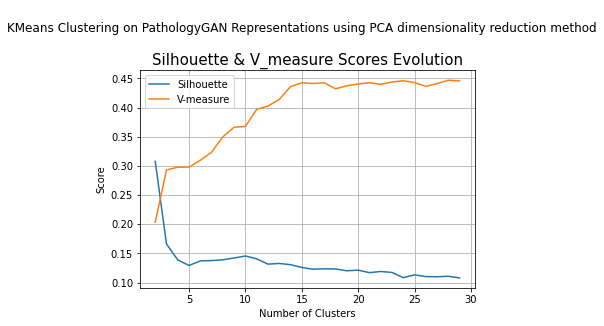

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.3078
Optimal Number of Clusters with reference to V_measure Score is K=28 with V_measure Score = 0.4467


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,1329
1,3671




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,98
1,109
2,89
3,285
4,294
5,409
6,177
7,160
8,51


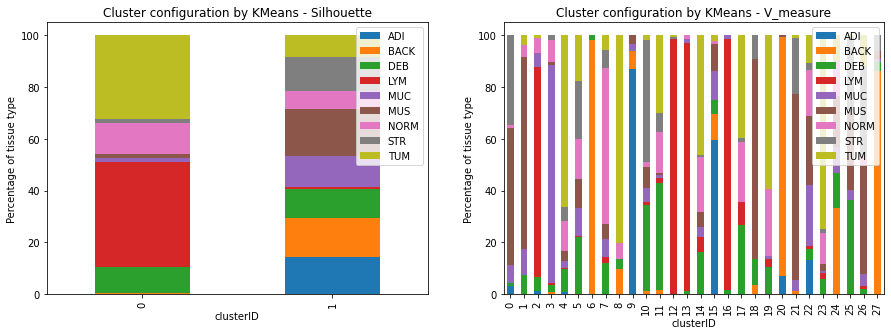

In [51]:
algorithm = "KMeans"
features = pge_pca_feature
rep = "PathologyGAN"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                KMeans
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.4118,0.2
3,0.4886,0.3055
4,0.5153,0.4641
5,0.5532,0.4793
6,0.588,0.5054
7,0.6157,0.5244
8,0.5453,0.5346
9,0.5308,0.5524
10,0.5296,0.5615
11,0.5502,0.5582


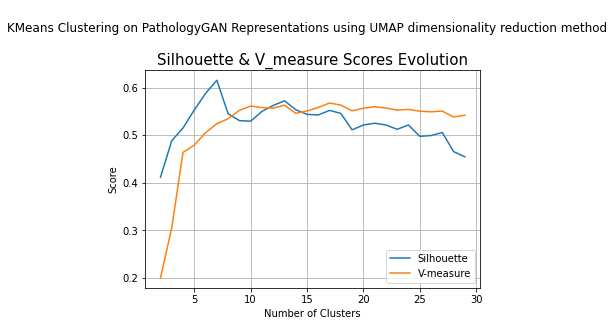

Optimal Number of Clusters with reference to Silhouette Score is K=7 with Silhouette Score = 0.6157
Optimal Number of Clusters with reference to V_measure Score is K=17 with V_measure Score = 0.5678


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,617
1,2218
2,551
3,386
4,1003
5,121
6,104




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,292
1,333
2,386
3,164
4,104
5,468
6,320
7,120
8,629


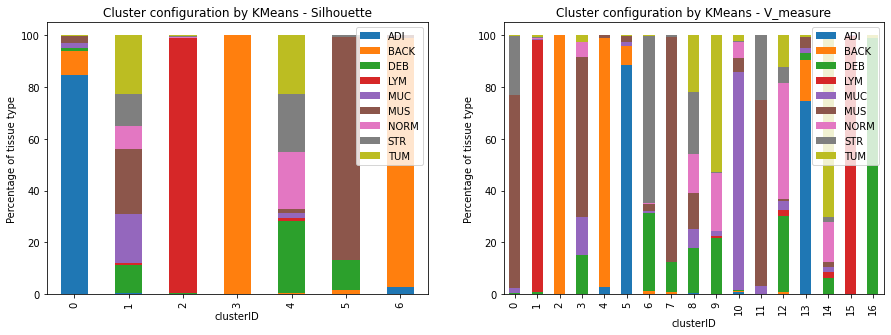

In [52]:
algorithm = "KMeans"
features = pge_umap_feature
rep = "PathologyGAN"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                KMeans
-Representations:                     ResNet50
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.1329,0.2225
3,0.147,0.4355
4,0.1671,0.4793
5,0.157,0.4782
6,0.1568,0.5222
7,0.1567,0.5211
8,0.1599,0.5103
9,0.1594,0.5077
10,0.1492,0.5039
11,0.1489,0.5117


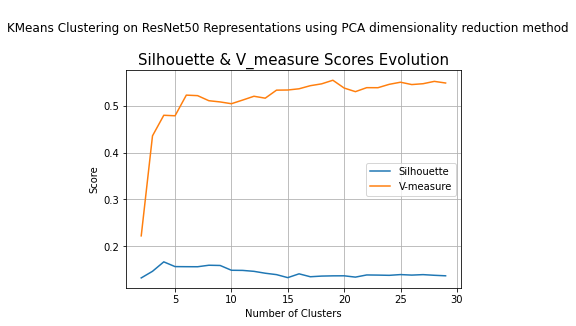

Optimal Number of Clusters with reference to Silhouette Score is K=4 with Silhouette Score = 0.1671
Optimal Number of Clusters with reference to V_measure Score is K=19 with V_measure Score = 0.5539


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,2828
1,1028
2,729
3,415




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,305
1,163
2,292
3,282
4,215
5,297
6,310
7,306
8,241


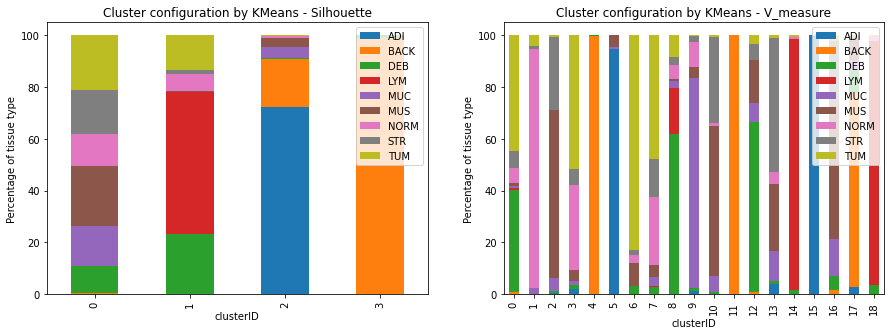

In [53]:
algorithm = "KMeans"
features = resnet50_pca_feature
rep = "ResNet50"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                KMeans
-Representations:                     ResNet50
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.4951,0.2501
3,0.5143,0.4279
4,0.5835,0.5266
5,0.443,0.6362
6,0.4794,0.6995
7,0.51,0.6816
8,0.5291,0.6777
9,0.5299,0.6551
10,0.5381,0.6525
11,0.5411,0.6558


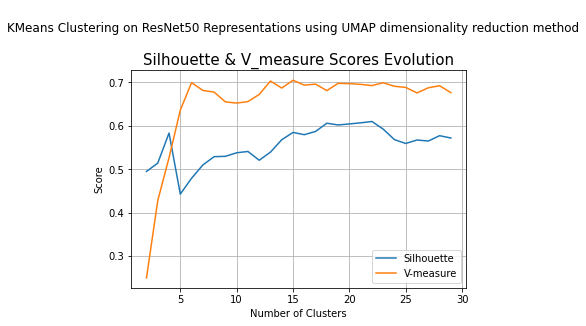

Optimal Number of Clusters with reference to Silhouette Score is K=22 with Silhouette Score = 0.6101
Optimal Number of Clusters with reference to V_measure Score is K=15 with V_measure Score = 0.705


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,120
1,412
2,530
3,740
4,210
5,253
6,60
7,438
8,20




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,298
1,438
2,530
3,210
4,581
5,60
6,740
7,377
8,91


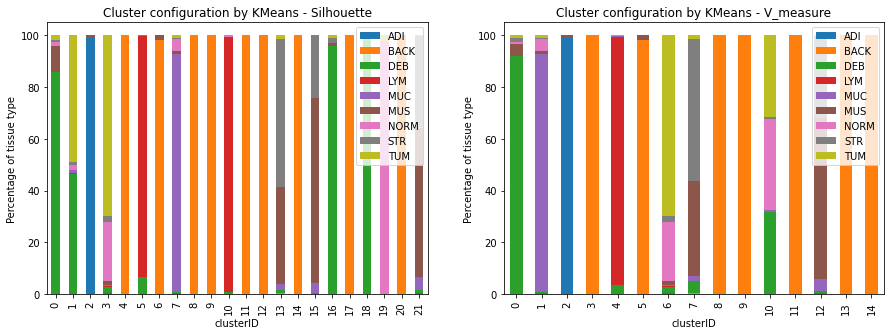

In [54]:
algorithm = "KMeans"
features = resnet50_umap_feature
rep = "ResNet50"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                KMeans
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.3312,0.2098
3,0.2516,0.2508
4,0.258,0.282
5,0.2422,0.2809
6,0.2263,0.2829
7,0.2276,0.3199
8,0.2251,0.3316
9,0.2239,0.3392
10,0.2121,0.334
11,0.2098,0.335


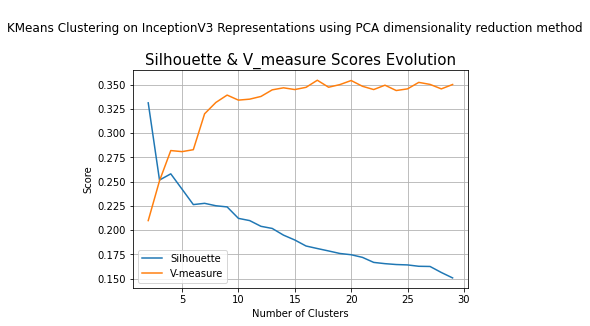

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.3312
Optimal Number of Clusters with reference to V_measure Score is K=17 with V_measure Score = 0.3545


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,1207
1,3793




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,394
1,270
2,241
3,238
4,354
5,331
6,336
7,274
8,316


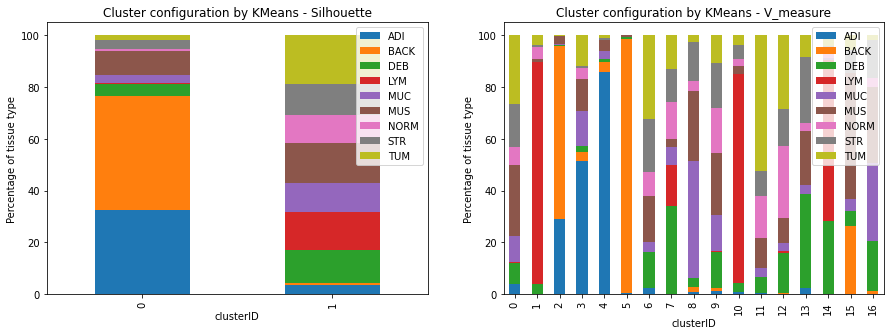

In [55]:
algorithm = "KMeans"
features = inceptionv3_pca_feature
rep = "InceptionV3"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                KMeans
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.6047,0.135
3,0.4575,0.2303
4,0.5182,0.3378
5,0.4379,0.3178
6,0.4617,0.3736
7,0.4659,0.3951
8,0.4433,0.375
9,0.4591,0.391
10,0.4575,0.3797
11,0.4631,0.3833


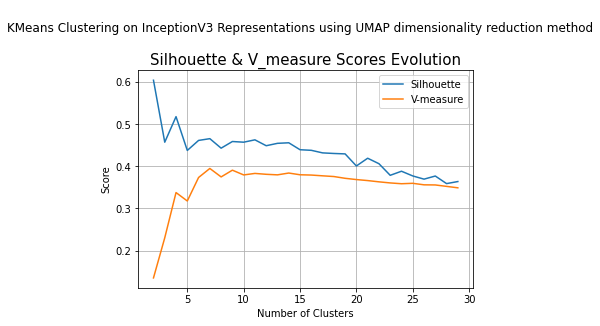

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.6047
Optimal Number of Clusters with reference to V_measure Score is K=7 with V_measure Score = 0.3951


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,4670
1,330




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,1060
1,608
2,962
3,182
4,330
5,580
6,1278


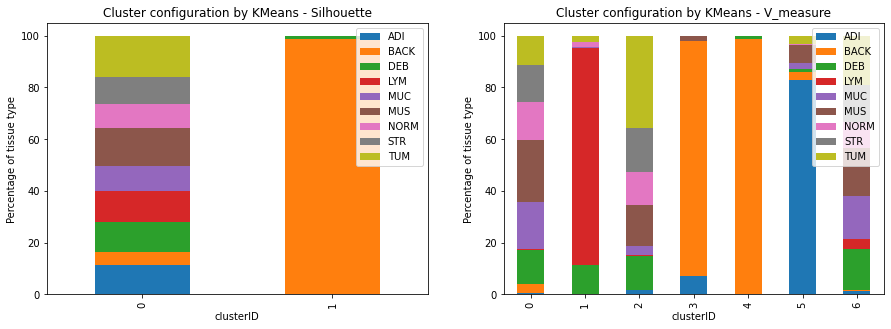

In [56]:
algorithm = "KMeans"
features = inceptionv3_umap_feature
rep = "InceptionV3"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                KMeans
-Representations:                     VGG16
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.1078,0.2808
3,0.144,0.455
4,0.1244,0.445
5,0.141,0.5149
6,0.1333,0.5715
7,0.1298,0.5701
8,0.1333,0.5647
9,0.1298,0.5554
10,0.1263,0.5504
11,0.1273,0.5529


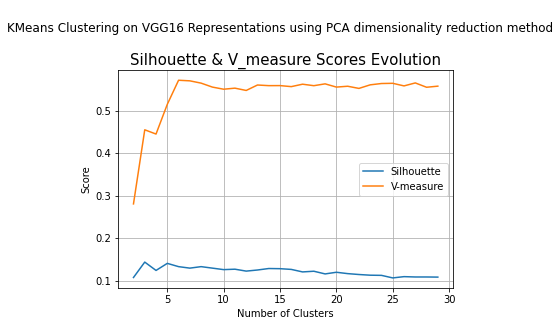

Optimal Number of Clusters with reference to Silhouette Score is K=3 with Silhouette Score = 0.144
Optimal Number of Clusters with reference to V_measure Score is K=6 with V_measure Score = 0.5715


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,1171
1,1033
2,2796




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,668
1,858
2,560
3,1350
4,1058
5,506


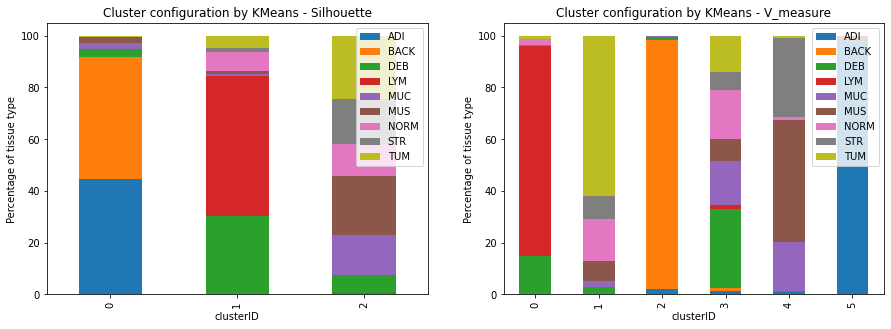

In [57]:
algorithm = "KMeans"
features = vgg16_pca_feature
rep = "VGG16"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                KMeans
-Representations:                     VGG16
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.5683,0.3761
3,0.5921,0.5104
4,0.6681,0.5801
5,0.5197,0.6933
6,0.536,0.6817
7,0.543,0.6581
8,0.5515,0.6526
9,0.5422,0.6972
10,0.5476,0.6946
11,0.5301,0.6838


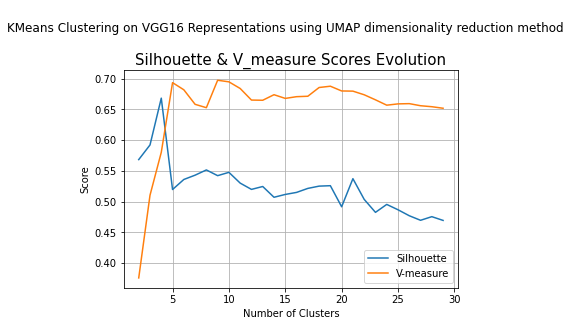

Optimal Number of Clusters with reference to Silhouette Score is K=4 with Silhouette Score = 0.6681
Optimal Number of Clusters with reference to V_measure Score is K=9 with V_measure Score = 0.6972


KMeans assignment counts - Silhouette


,Number of members
Cluster Index,
0,3398
1,516
2,555
3,531




KMeans assignment counts - V_measure


,Number of members
Cluster Index,
0,869
1,531
2,348
3,516
4,145
5,1106
6,901
7,62
8,522


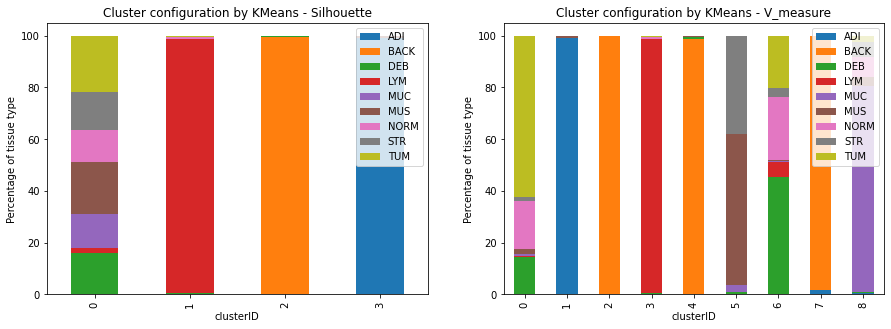

In [58]:
algorithm = "KMeans"
features = vgg16_umap_feature
rep = "VGG16"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

# GMM Clustering Implementation

-Clustering Algorithm:                GMM
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.1914,0.2086
3,0.1282,0.3882
4,0.1189,0.3604
5,0.1172,0.3368
6,0.1254,0.3404
7,0.1299,0.3449
8,0.1309,0.3721
9,0.1342,0.3877
10,0.1271,0.4177
11,0.1203,0.4405


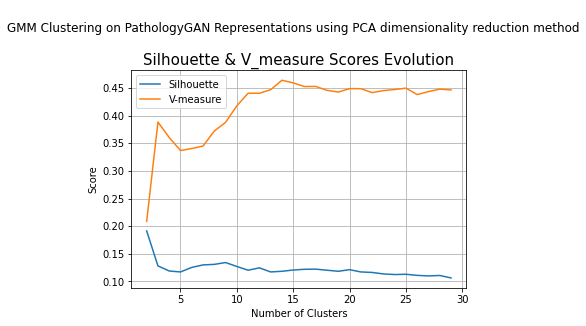

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.1914
Optimal Number of Clusters with reference to V_measure Score is K=14 with V_measure Score = 0.4639


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,2434
1,2566




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,346
1,266
2,322
3,473
4,163
5,525
6,559
7,523
8,133


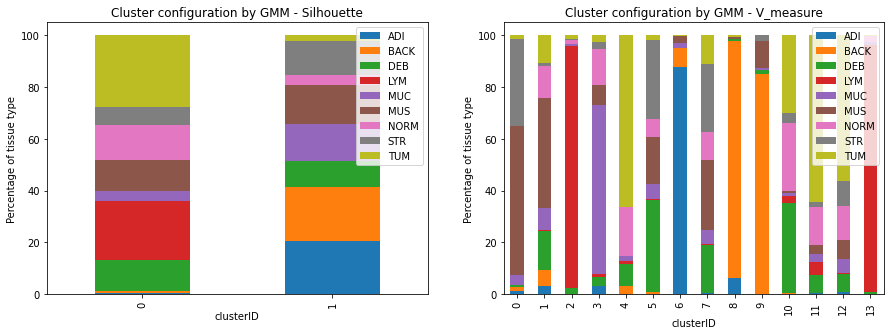

In [59]:
algorithm = "GMM"
features = pge_pca_feature
rep = "PathologyGAN"
dim_red = "PCA"


results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                GMM
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.3325,0.2595
3,0.4612,0.289
4,0.5128,0.4386
5,0.5507,0.4804
6,0.5109,0.4822
7,0.5065,0.4833
8,0.5356,0.5369
9,0.5401,0.5489
10,0.5329,0.5679
11,0.5355,0.5557


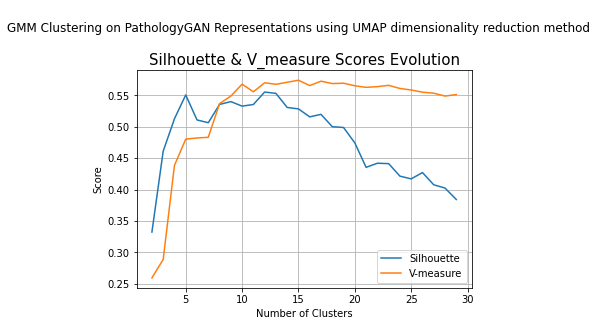

Optimal Number of Clusters with reference to Silhouette Score is K=12 with Silhouette Score = 0.5553
Optimal Number of Clusters with reference to V_measure Score is K=15 with V_measure Score = 0.5741


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,319
1,551
2,386
3,146
4,104
5,468
6,354
7,120
8,1016




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,291
1,551
2,386
3,239
4,104
5,468
6,358
7,120
8,667


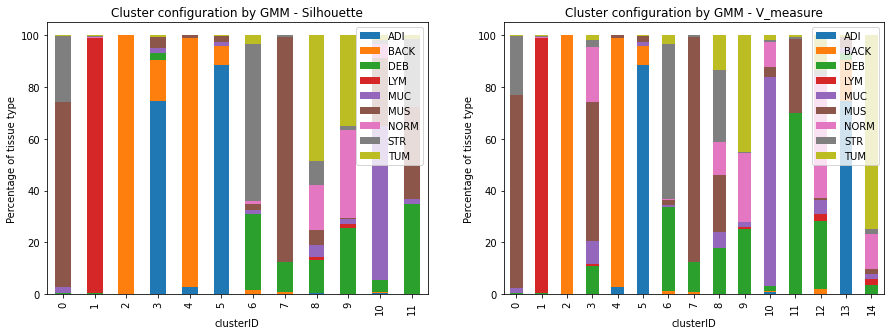

In [60]:
algorithm = "GMM"
features = pge_umap_feature
rep = "PathologyGAN"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                GMM
-Representations:                     ResNet50
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.1123,0.2819
3,0.1426,0.3294
4,0.1557,0.5234
5,0.1468,0.5033
6,0.1518,0.5794
7,0.1474,0.5706
8,0.1484,0.5375
9,0.1555,0.5438
10,0.1469,0.5394
11,0.1374,0.5251


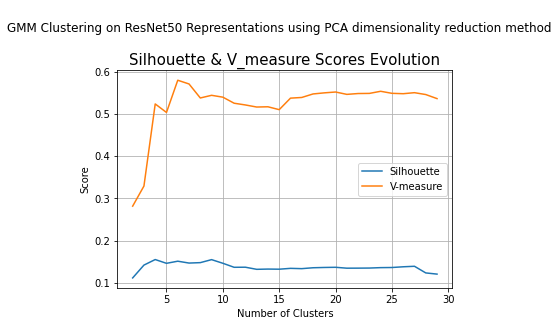

Optimal Number of Clusters with reference to Silhouette Score is K=4 with Silhouette Score = 0.1557
Optimal Number of Clusters with reference to V_measure Score is K=6 with V_measure Score = 0.5794


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,2672
1,1189
2,426
3,713




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,920
1,1229
2,406
3,498
4,1179
5,768


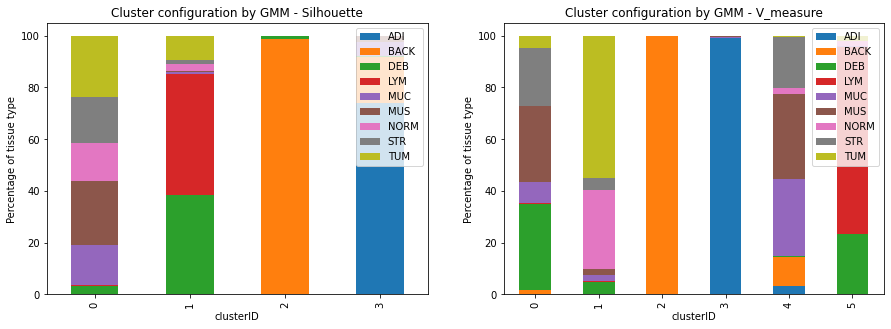

In [61]:
algorithm = "GMM"
features = resnet50_pca_feature
rep = "ResNet50"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                GMM
-Representations:                     ResNet50
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.4012,0.252
3,0.5074,0.5204
4,0.5689,0.5303
5,0.5907,0.5731
6,0.4786,0.7142
7,0.5082,0.6861
8,0.5014,0.7016
9,0.5157,0.6948
10,0.4982,0.6994
11,0.5066,0.6961


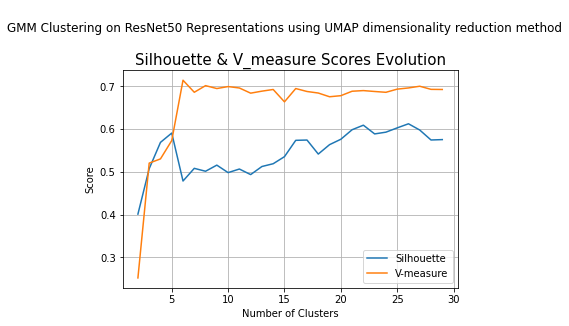

Optimal Number of Clusters with reference to Silhouette Score is K=26 with Silhouette Score = 0.6124
Optimal Number of Clusters with reference to V_measure Score is K=6 with V_measure Score = 0.7142


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,285
1,249
2,530
3,210
4,748
5,57
6,134
7,105
8,34




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,1653
1,581
2,1685
3,530
4,236
5,315


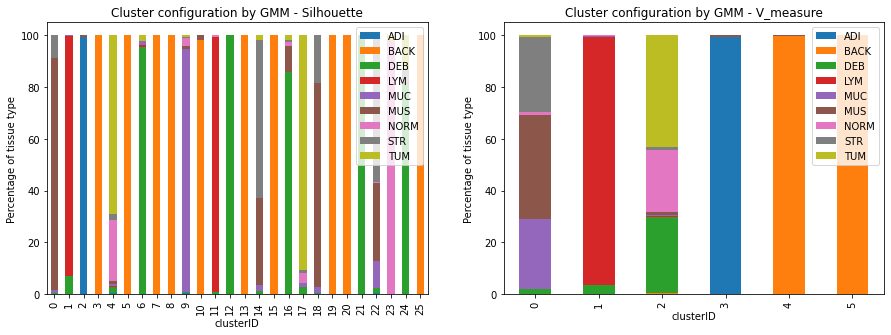

In [62]:
algorithm = "GMM"
features = resnet50_umap_feature
rep = "ResNet50"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                GMM
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.3129,0.2383
3,0.2423,0.2714
4,0.23,0.3076
5,0.2121,0.3207
6,0.1924,0.3054
7,0.1977,0.341
8,0.1973,0.3477
9,0.2109,0.3429
10,0.2012,0.3467
11,0.1943,0.351


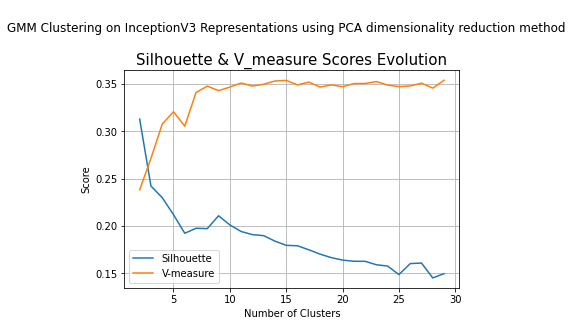

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.3129
Optimal Number of Clusters with reference to V_measure Score is K=29 with V_measure Score = 0.3539


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,3756
1,1244




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,58
1,252
2,69
3,187
4,151
5,186
6,272
7,85
8,198


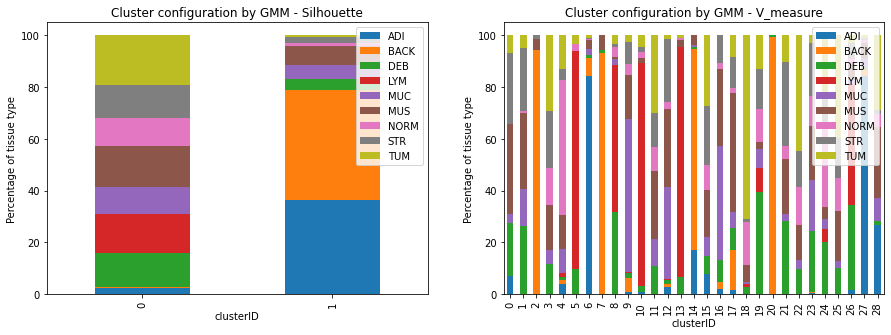

In [63]:
algorithm = "GMM"
features = inceptionv3_pca_feature
rep = "InceptionV3"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                GMM
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.471,0.2843
3,0.4888,0.2983
4,0.5081,0.3408
5,0.3928,0.36
6,0.4171,0.3776
7,0.4452,0.3942
8,0.424,0.3878
9,0.4361,0.4002
10,0.437,0.3979
11,0.4354,0.3919


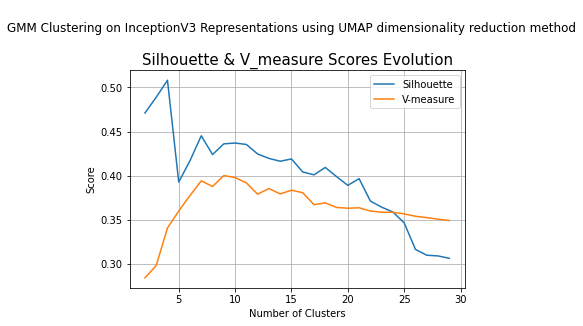

Optimal Number of Clusters with reference to Silhouette Score is K=4 with Silhouette Score = 0.5081
Optimal Number of Clusters with reference to V_measure Score is K=9 with V_measure Score = 0.4002


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,1699
1,2203
2,330
3,768




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,367
1,1484
2,330
3,179
4,436
5,833
6,402
7,379
8,590


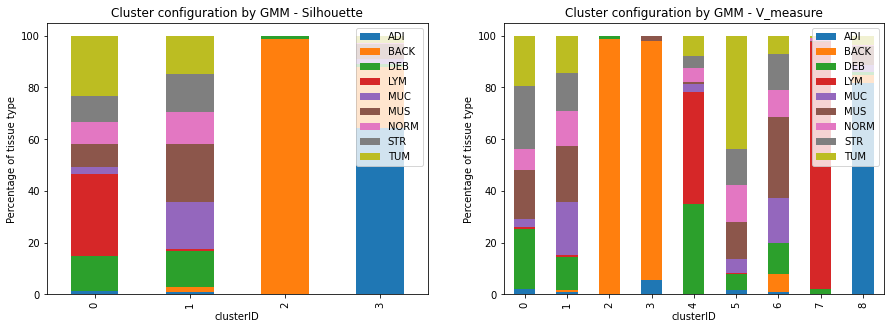

In [64]:
algorithm = "GMM"
features = inceptionv3_umap_feature
rep = "InceptionV3"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                GMM
-Representations:                     VGG16
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.114,0.3664
3,0.1339,0.5179
4,0.1254,0.5916
5,0.0885,0.5648
6,0.0907,0.5495
7,0.1232,0.5965
8,0.1194,0.5843
9,0.1193,0.5746
10,0.1185,0.5769
11,0.1216,0.5934


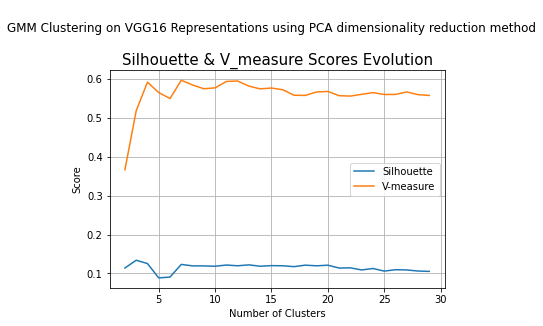

Optimal Number of Clusters with reference to Silhouette Score is K=3 with Silhouette Score = 0.1339
Optimal Number of Clusters with reference to V_measure Score is K=7 with V_measure Score = 0.5965


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,2803
1,1096
2,1101




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,780
1,535
2,752
3,552
4,538
5,963
6,880


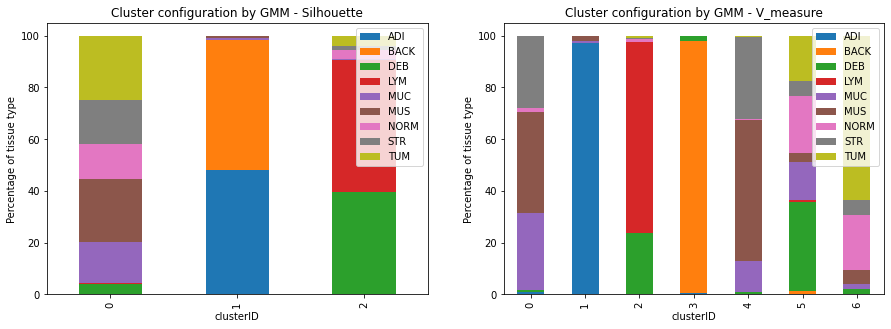

In [65]:
algorithm = "GMM"
features = vgg16_pca_feature
rep = "VGG16"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                GMM
-Representations:                     VGG16
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.4186,0.2279
3,0.3393,0.4995
4,0.6681,0.5801
5,0.5041,0.6593
6,0.364,0.6199
7,0.489,0.6773
8,0.4323,0.7136
9,0.4408,0.7078
10,0.4459,0.7051
11,0.4778,0.7134


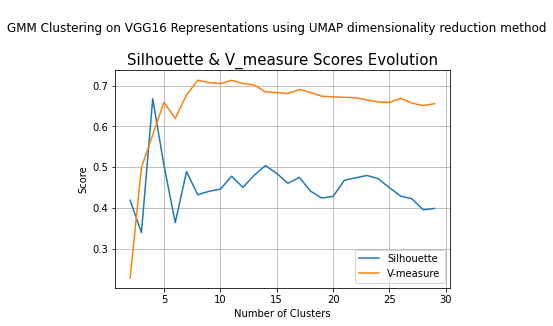

Optimal Number of Clusters with reference to Silhouette Score is K=4 with Silhouette Score = 0.6681
Optimal Number of Clusters with reference to V_measure Score is K=8 with V_measure Score = 0.7136


GMM assignment counts - Silhouette


,Number of members
Cluster Index,
0,3398
1,516
2,555
3,531




GMM assignment counts - V_measure


,Number of members
Cluster Index,
0,434
1,551
2,410
3,531
4,516
5,145
6,1221
7,1192


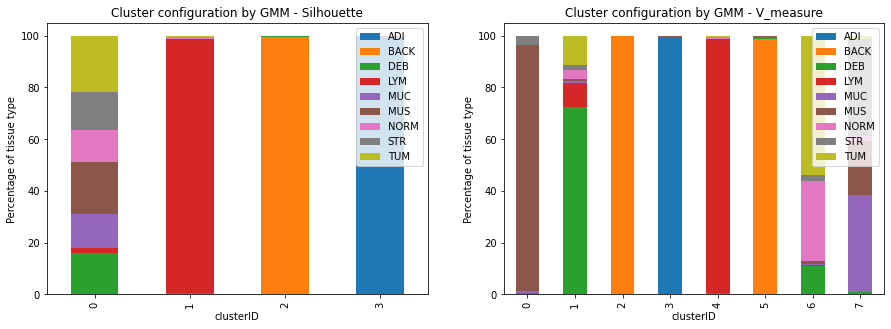

In [66]:
algorithm = "GMM"
features = vgg16_umap_feature
rep = "VGG16"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

# Hierarchical Clustering Implementation

-Clustering Algorithm:                Hierarchical
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.32,0.1124
3,0.1377,0.2206
4,0.0965,0.3008
5,0.0797,0.3185
6,0.0956,0.352
7,0.0999,0.3506
8,0.1048,0.3787
9,0.1096,0.375
10,0.1041,0.3882
11,0.1084,0.3968


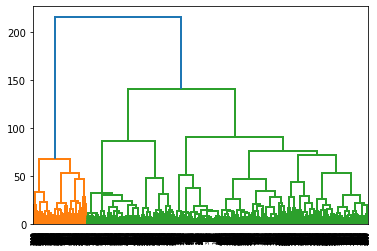

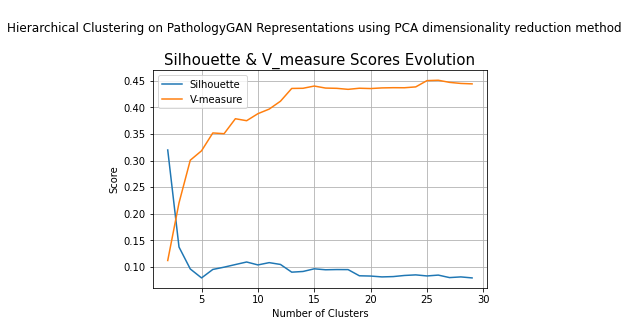

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.32
Optimal Number of Clusters with reference to V_measure Score is K=26 with V_measure Score = 0.451


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,4201
1,799




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,463
1,293
2,511
3,236
4,30
5,121
6,184
7,197
8,233


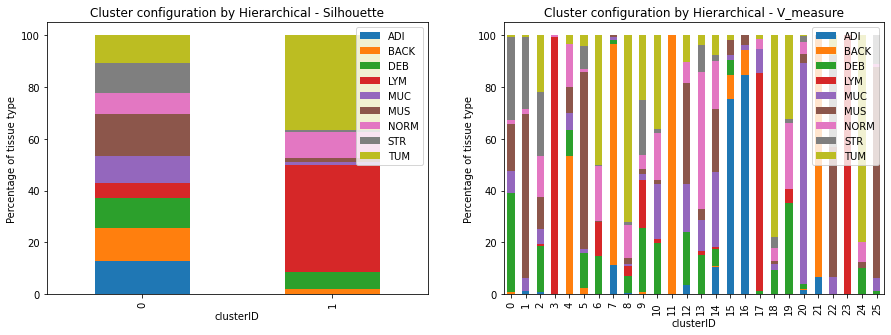

In [67]:
algorithm = "Hierarchical"
features = pge_pca_feature
rep = "PathologyGAN"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                Hierarchical
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.3812,0.1776
3,0.4699,0.2637
4,0.5033,0.3935
5,0.5531,0.4803
6,0.5881,0.506
7,0.615,0.525
8,0.5335,0.5437
9,0.551,0.5532
10,0.5396,0.5587
11,0.531,0.5581


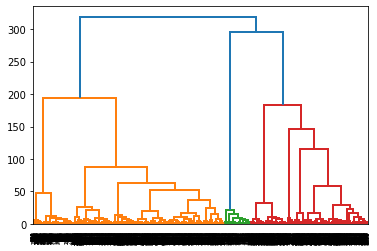

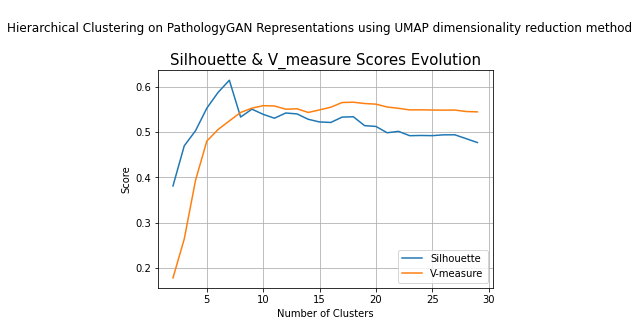

Optimal Number of Clusters with reference to Silhouette Score is K=7 with Silhouette Score = 0.615
Optimal Number of Clusters with reference to V_measure Score is K=18 with V_measure Score = 0.5664


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,2249
1,976
2,386
3,613
4,551
5,104
6,121




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,386
1,458
2,536
3,225
4,484
5,311
6,121
7,134
8,315


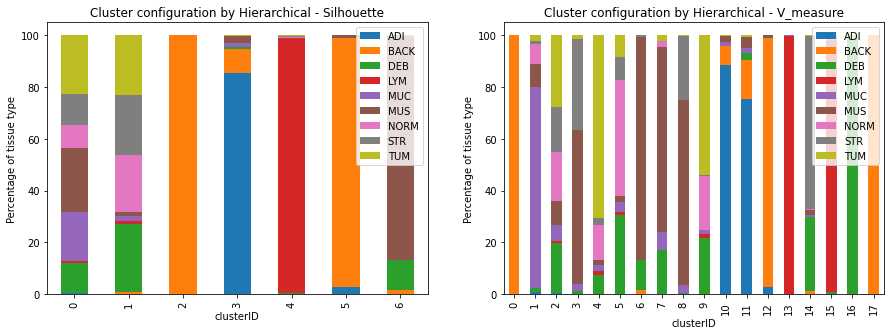

In [68]:
algorithm = "Hierarchical"
features = pge_umap_feature
rep = "PathologyGAN"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                Hierarchical
-Representations:                     ResNet50
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.1284,0.2469
3,0.1335,0.4438
4,0.1516,0.5041
5,0.1362,0.572
6,0.1298,0.554
7,0.1318,0.5478
8,0.122,0.5449
9,0.1213,0.5562
10,0.1156,0.5703
11,0.1156,0.5669


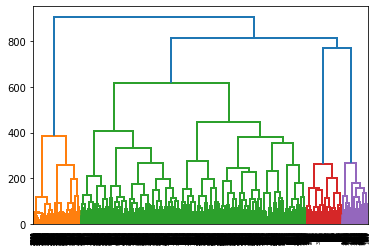

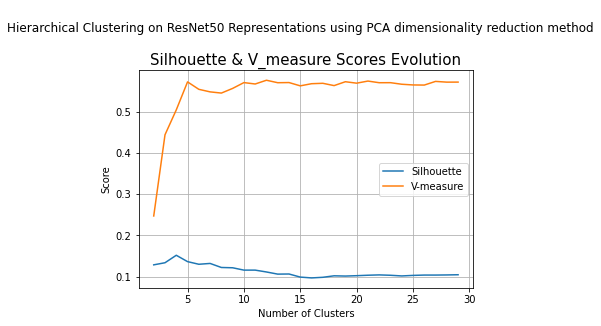

Optimal Number of Clusters with reference to Silhouette Score is K=4 with Silhouette Score = 0.1516
Optimal Number of Clusters with reference to V_measure Score is K=12 with V_measure Score = 0.576


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,3370
1,715
2,381
3,534




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,381
1,534
2,761
3,340
4,401
5,359
6,434
7,314
8,617


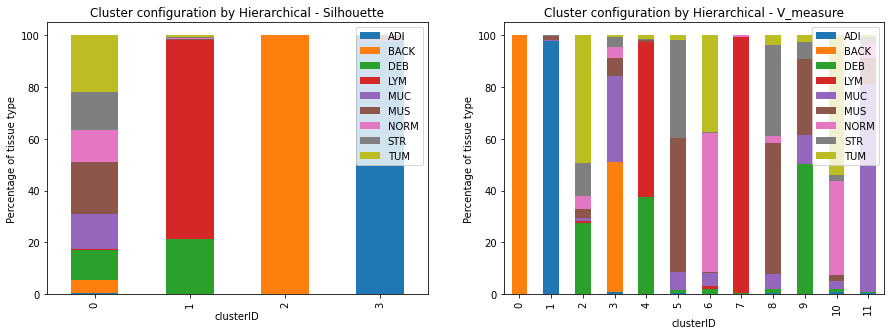

In [69]:
algorithm = "Hierarchical"
features = resnet50_pca_feature
rep = "ResNet50"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                Hierarchical
-Representations:                     ResNet50
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.4942,0.2622
3,0.5093,0.4442
4,0.5792,0.5482
5,0.6101,0.59
6,0.4788,0.7108
7,0.4887,0.6794
8,0.503,0.6725
9,0.5118,0.6693
10,0.52,0.6653
11,0.5268,0.6629


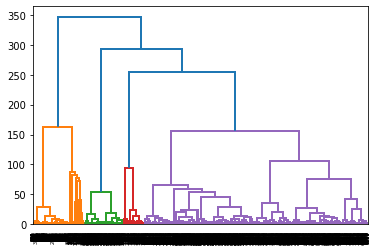

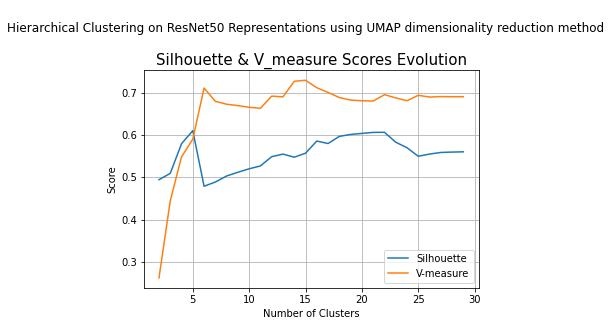

Optimal Number of Clusters with reference to Silhouette Score is K=5 with Silhouette Score = 0.6101
Optimal Number of Clusters with reference to V_measure Score is K=15 with V_measure Score = 0.7292


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,3338
1,315
2,581
3,236
4,530




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,1186
1,387
2,581
3,210
4,31
5,91
6,566
7,105
8,34


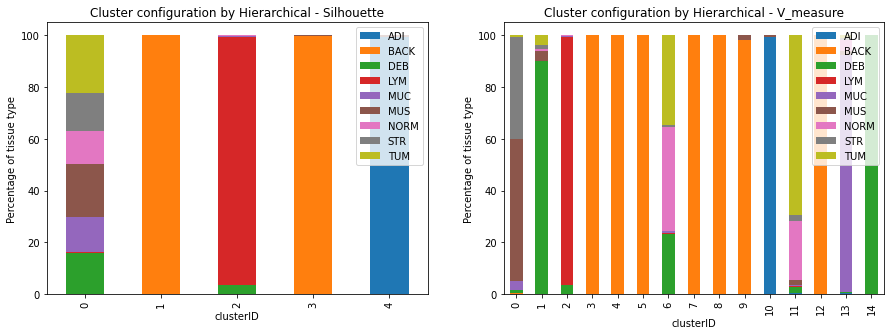

In [70]:
algorithm = "Hierarchical"
features = resnet50_umap_feature
rep = "ResNet50"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                Hierarchical
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.3494,0.215
3,0.2344,0.2419
4,0.1979,0.2375
5,0.2081,0.2515
6,0.2011,0.25
7,0.1992,0.2896
8,0.1931,0.3037
9,0.1944,0.3451
10,0.1796,0.3375
11,0.1706,0.3477


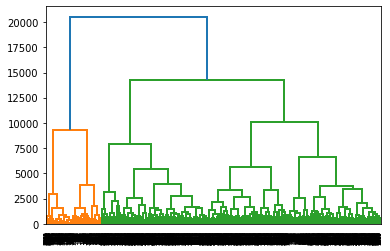

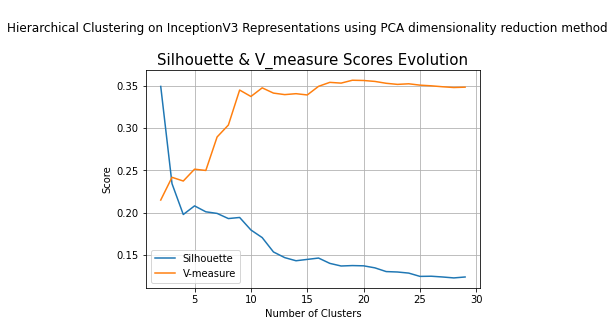

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.3494
Optimal Number of Clusters with reference to V_measure Score is K=19 with V_measure Score = 0.3567


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,4165
1,835




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,427
1,404
2,331
3,180
4,223
5,281
6,317
7,168
8,398


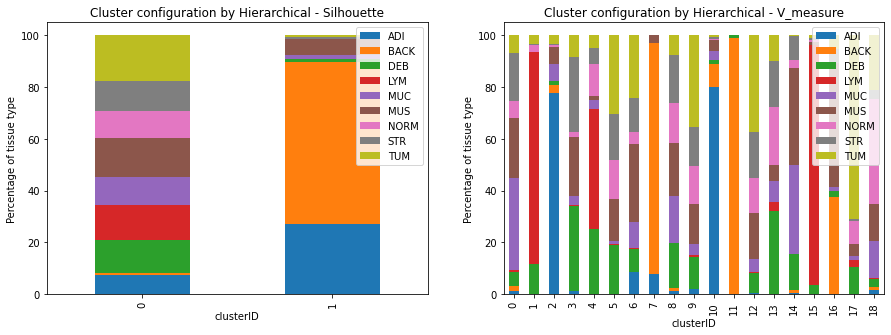

In [71]:
algorithm = "Hierarchical"
features = inceptionv3_pca_feature
rep = "InceptionV3"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                Hierarchical
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.6047,0.135
3,0.448,0.2207
4,0.5142,0.3322
5,0.5001,0.4061
6,0.4325,0.3897
7,0.4408,0.41
8,0.4256,0.4028
9,0.401,0.3864
10,0.4125,0.3824
11,0.415,0.381


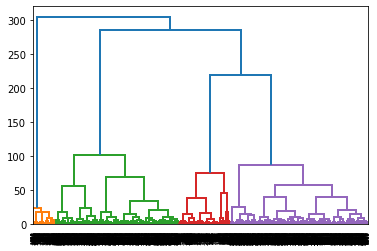

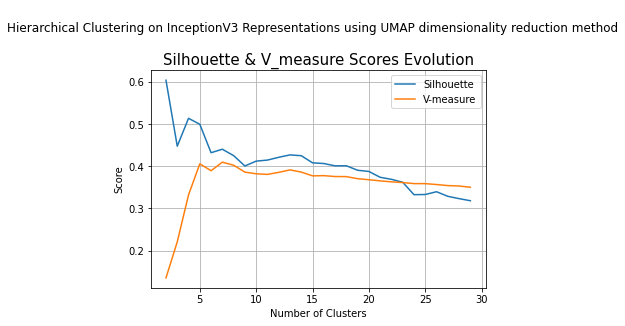

Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.6047
Optimal Number of Clusters with reference to V_measure Score is K=7 with V_measure Score = 0.41


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,4670
1,330




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,1192
1,1647
2,172
3,330
4,657
5,408
6,594


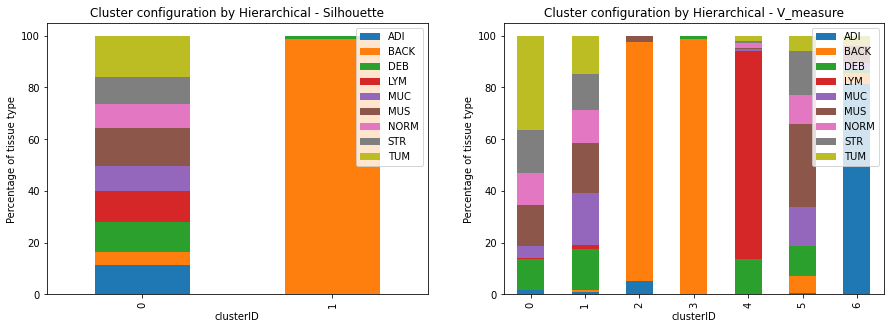

In [72]:
algorithm = "Hierarchical"
features = inceptionv3_umap_feature
rep = "InceptionV3"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                Hierarchical
-Representations:                     VGG16
-Dimensionality Reduction Method:     PCA


n_clusters,silhouette score,v_measure score
2,0.1347,0.3679
3,0.1416,0.4973
4,0.1166,0.5654
5,0.1225,0.6371
6,0.1203,0.644
7,0.1186,0.627
8,0.1042,0.6383
9,0.1074,0.6391
10,0.103,0.6298
11,0.1001,0.6202


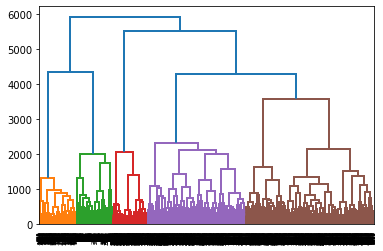

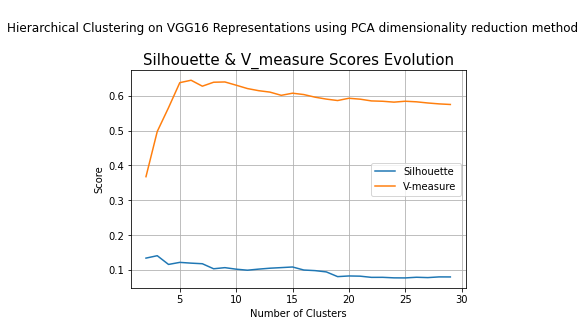

Optimal Number of Clusters with reference to Silhouette Score is K=3 with Silhouette Score = 0.1416
Optimal Number of Clusters with reference to V_measure Score is K=6 with V_measure Score = 0.644


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,1099
1,3379
2,522




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,1462
1,1302
2,522
3,559
4,540
5,615


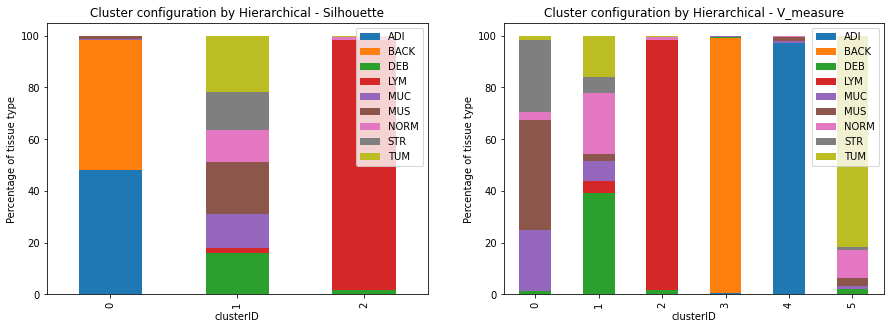

In [73]:
algorithm = "Hierarchical"
features = vgg16_pca_feature
rep = "VGG16"
dim_red = "PCA"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

-Clustering Algorithm:                Hierarchical
-Representations:                     VGG16
-Dimensionality Reduction Method:     UMAP


n_clusters,silhouette score,v_measure score
2,0.5683,0.3761
3,0.5921,0.5104
4,0.6681,0.5801
5,0.5124,0.7052
6,0.5288,0.6933
7,0.5389,0.6712
8,0.5474,0.6655
9,0.5323,0.6897
10,0.5377,0.6871
11,0.5252,0.6778


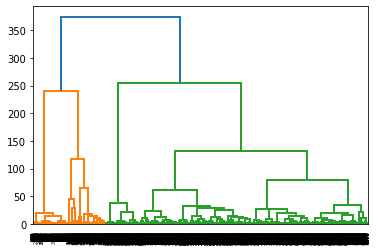

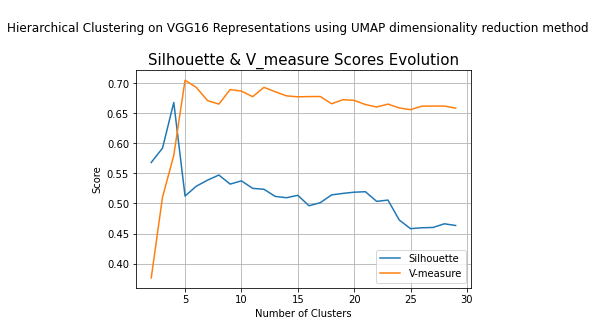

Optimal Number of Clusters with reference to Silhouette Score is K=4 with Silhouette Score = 0.6681
Optimal Number of Clusters with reference to V_measure Score is K=5 with V_measure Score = 0.7052


Hierarchical assignment counts - Silhouette


,Number of members
Cluster Index,
0,3398
1,555
2,516
3,531




Hierarchical assignment counts - V_measure


,Number of members
Cluster Index,
0,555
1,1728
2,516
3,531
4,1670


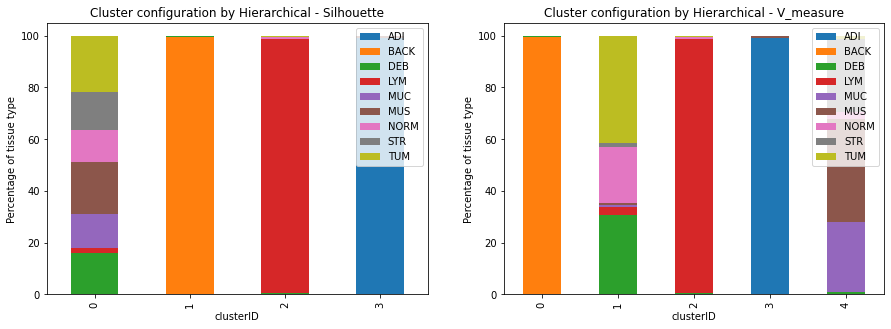

In [74]:
algorithm = "Hierarchical"
features = vgg16_umap_feature
rep = "VGG16"
dim_red = "UMAP"

results = iterative_clustering(algorithm, N_CLUSTERS, features, labels, rep, dim_red)

# Louvain Clustering Implementation

-Clustering Algorithm:                Louvain
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     PCA


n_clusters,resolution,modularity,silhouette score,v_measure score
3,0.4,potts,0.5586,0.0027
3,0.5,potts,0.5054,0.0059
5,0.6,potts,0.4025,0.0346
6,0.7,potts,0.4226,0.0842
13,0.8,potts,0.2225,0.1169
2,0.9,dugue,0.4369,0.2152
2,0.9,newman,0.428,0.2156
27,0.9,potts,0.0914,0.1598
2,0.95,dugue,0.3856,0.2278
6,0.95,newman,-0.0775,0.2278


Optimal Number of Clusters with reference to Silhouette Score is K=3 with Silhouette Score = 0.5586 
(given by resolution=0.4 and Potts modularity)
Optimal Number of Clusters with reference to V_measure Score is K=11 with V_measure Score = 0.2597 
(given by resolution=0.99995 and Newman modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,4991
1,6
2,3




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,2563
1,1682
2,583
3,94
4,43
5,13
6,8
7,8
8,3


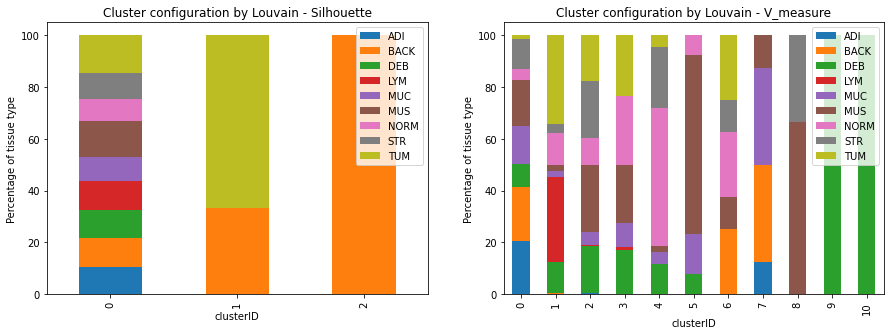

In [9]:
algorithm = "Louvain"
features = pge_pca_feature
rep = "PathologyGAN"
dim_red = "PCA"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)

-Clustering Algorithm:                Louvain
-Representations:                     PathologyGAN
-Dimensionality Reduction Method:     UMAP


n_clusters,resolution,modularity,silhouette score,v_measure score
2,0.2,potts,0.4133,0.0004
2,0.3,potts,0.4133,0.0004
4,0.4,potts,0.4778,0.1678
6,0.5,potts,0.4591,0.2128
7,0.6,potts,0.3707,0.2318
8,0.7,potts,0.5316,0.4081
3,0.8,dugue,0.4518,0.2696
8,0.8,potts,0.5328,0.4107
3,0.9,dugue,0.472,0.3078
2,0.9,newman,0.3242,0.1704


Optimal Number of Clusters with reference to Silhouette Score is K=8 with Silhouette Score = 0.5328 
(given by resolution=0.8 and Potts modularity)
Optimal Number of Clusters with reference to V_measure Score is K=8 with V_measure Score = 0.4107 
(given by resolution=0.8 and Potts modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,3836
1,551
2,386
3,119
4,104
5,2
6,1
7,1




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,3836
1,551
2,386
3,119
4,104
5,2
6,1
7,1


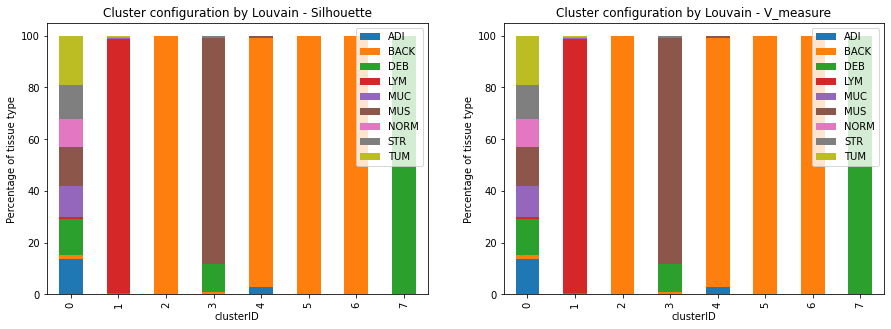

In [10]:
algorithm = "Louvain"
features = pge_umap_feature
rep = "PathologyGAN"
dim_red = "UMAP"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)

-Clustering Algorithm:                Louvain
-Representations:                     ResNet50
-Dimensionality Reduction Method:     PCA


n_clusters,resolution,modularity,silhouette score,v_measure score
2,0.4,potts,0.5085,0.0006
4,0.5,potts,0.4081,0.0092
4,0.6,potts,0.3436,0.0295
6,0.7,potts,0.2425,0.1084
8,0.8,potts,0.1701,0.204
2,0.9,dugue,0.2109,0.2341
2,0.9,newman,0.2118,0.2367
12,0.9,potts,0.1637,0.3637
2,0.95,dugue,0.2031,0.2509
5,0.95,newman,-0.0722,0.2524


Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.5085 
(given by resolution=0.4 and Potts modularity)
Optimal Number of Clusters with reference to V_measure Score is K=18 with V_measure Score = 0.4128 
(given by resolution=0.9995 and Potts modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,4998
1,2




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,3175
1,881
2,387
3,337
4,58
5,41
6,33
7,32
8,22


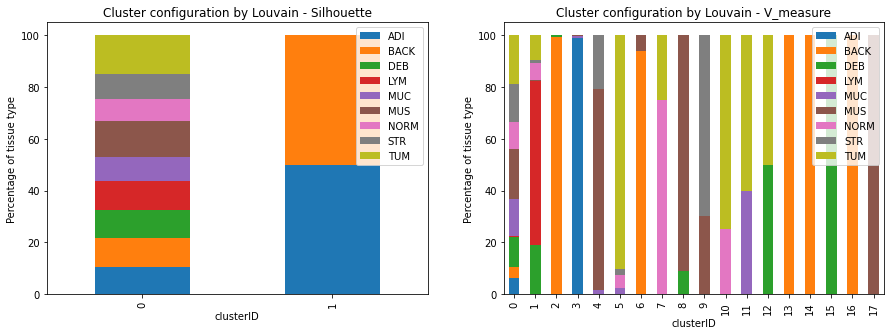

In [11]:
algorithm = "Louvain"
features = resnet50_pca_feature
rep = "ResNet50"
dim_red = "PCA"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)

-Clustering Algorithm:                Louvain
-Representations:                     ResNet50
-Dimensionality Reduction Method:     UMAP


n_clusters,resolution,modularity,silhouette score,v_measure score
3,0.3,potts,0.3819,0.0012
5,0.4,potts,0.2887,0.0068
9,0.5,potts,0.4287,0.2679
12,0.6,potts,0.5386,0.4062
15,0.7,potts,0.5682,0.4104
17,0.8,potts,0.6677,0.4869
4,0.9,dugue,0.4766,0.4893
2,0.9,newman,0.2275,0.2471
17,0.9,potts,0.7156,0.5542
4,0.95,dugue,0.4719,0.4928


Optimal Number of Clusters with reference to Silhouette Score is K=17 with Silhouette Score = 0.7156 
(given by resolution=0.9 and Potts modularity)
Optimal Number of Clusters with reference to V_measure Score is K=5 with V_measure Score = 0.5809 
(given by resolution=0.99995 and Dugue modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,3378
1,530
2,523
3,208
4,105
5,90
6,60
7,34
8,20




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,1681
1,1447
2,819
3,738
4,315


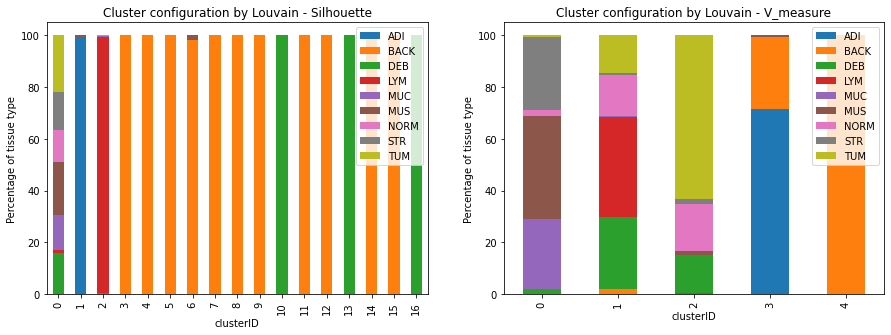

In [12]:
algorithm = "Louvain"
features = resnet50_umap_feature
rep = "ResNet50"
dim_red = "UMAP"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)

-Clustering Algorithm:                Louvain
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     PCA


n_clusters,resolution,modularity,silhouette score,v_measure score
2,0.5,potts,0.4116,0.0021
2,0.6,potts,0.3775,0.003
3,0.7,potts,0.4433,0.1853
2,0.8,dugue,0.4622,0.2296
3,0.8,potts,0.4036,0.2139
2,0.9,dugue,0.3736,0.1808
4,0.9,newman,-0.1072,0.1601
4,0.9,potts,0.3126,0.2336
2,0.95,dugue,0.3486,0.1649
5,0.95,newman,0.018,0.1835


Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.4622 
(given by resolution=0.8 and Dugue modularity)
Optimal Number of Clusters with reference to V_measure Score is K=12 with V_measure Score = 0.2761 
(given by resolution=0.99995 and Potts modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,3876
1,1124




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,3231
1,815
2,531
3,396
4,9
5,5
6,3
7,3
8,3


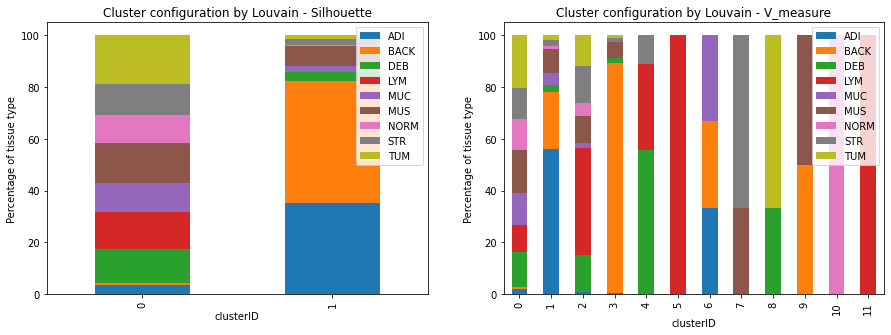

In [13]:
algorithm = "Louvain"
features = inceptionv3_pca_feature
rep = "InceptionV3"
dim_red = "PCA"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)

-Clustering Algorithm:                Louvain
-Representations:                     InceptionV3
-Dimensionality Reduction Method:     UMAP


n_clusters,resolution,modularity,silhouette score,v_measure score
2,0.2,potts,0.5485,0.0004
2,0.3,potts,0.5485,0.0004
3,0.4,potts,0.6081,0.1354
3,0.5,potts,0.4864,0.1423
3,0.6,potts,0.4947,0.1872
4,0.7,potts,0.4937,0.2098
2,0.8,dugue,0.611,0.135
4,0.8,potts,0.4849,0.2287
3,0.9,dugue,0.4536,0.2304
2,0.9,newman,0.3495,0.1566


Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.611 
(given by resolution=0.8 and Dugue modularity)
Optimal Number of Clusters with reference to V_measure Score is K=7 with V_measure Score = 0.3371 
(given by resolution=0.9995 and Potts modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,4670
1,330




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,3528
1,723
2,353
3,328
4,65
5,2
6,1


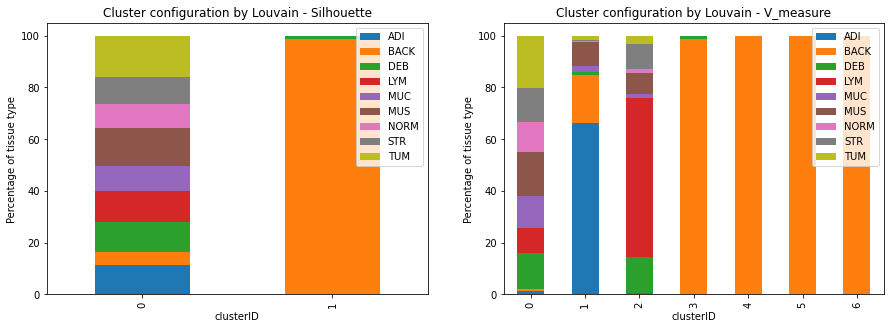

In [14]:
algorithm = "Louvain"
features = inceptionv3_umap_feature
rep = "InceptionV3"
dim_red = "UMAP"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)

-Clustering Algorithm:                Louvain
-Representations:                     VGG16
-Dimensionality Reduction Method:     PCA


n_clusters,resolution,modularity,silhouette score,v_measure score
2,0.2,potts,0.8372,0.0004
2,0.3,potts,0.8372,0.0004
2,0.4,potts,0.8372,0.0004
2,0.5,potts,0.705,0.0029
3,0.6,potts,0.6216,0.0085
4,0.7,potts,0.5088,0.0259
10,0.8,potts,0.3688,0.0642
2,0.9,newman,0.4272,0.055
20,0.9,potts,0.14,0.1535
2,0.95,newman,0.3549,0.1295


Optimal Number of Clusters with reference to Silhouette Score is K=2 with Silhouette Score = 0.8372 
(given by resolution=0.2 and Potts modularity)
Optimal Number of Clusters with reference to V_measure Score is K=5 with V_measure Score = 0.4346 
(given by resolution=0.99 and Newman modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,4999
1,1




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,2308
1,1544
2,1138
3,7
4,3


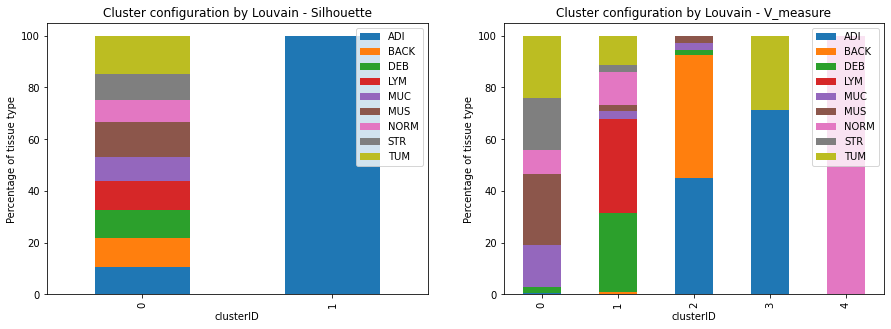

In [15]:
algorithm = "Louvain"
features = vgg16_pca_feature
rep = "VGG16"
dim_red = "PCA"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)

-Clustering Algorithm:                Louvain
-Representations:                     VGG16
-Dimensionality Reduction Method:     UMAP


n_clusters,resolution,modularity,silhouette score,v_measure score
2,0.4,potts,0.6342,0.3513
4,0.5,potts,0.6002,0.4128
5,0.6,potts,0.5614,0.4561
2,0.7,dugue,0.642,0.3761
5,0.7,potts,0.5614,0.4561
2,0.8,dugue,0.642,0.3761
2,0.8,newman,0.642,0.3761
6,0.8,potts,0.6124,0.4961
2,0.9,dugue,0.642,0.3761
3,0.9,newman,0.3493,0.5592


Optimal Number of Clusters with reference to Silhouette Score is K=7 with Silhouette Score = 0.7331 
(given by resolution=0.9 and Potts modularity)
Optimal Number of Clusters with reference to V_measure Score is K=3 with V_measure Score = 0.575 
(given by resolution=0.9995 and Dugue modularity)


Louvain assignment counts - Silhouette


,Number of members
Cluster Index,
0,3397
1,531
2,516
3,410
4,110
5,35
6,1




Louvain assignment counts - V_measure


,Number of members
Cluster Index,
0,2286
1,1628
2,1086


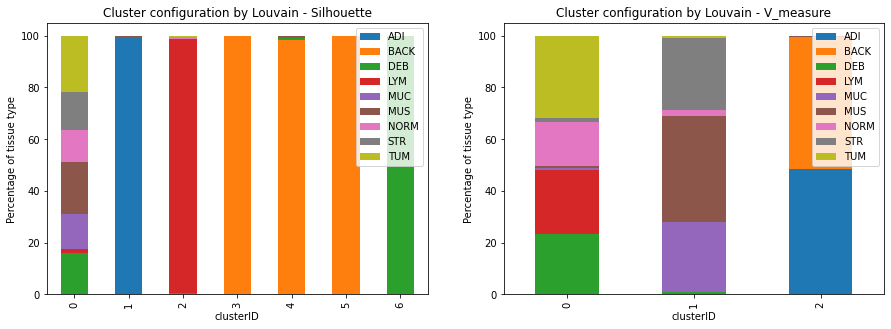

In [16]:
algorithm = "Louvain"
features = vgg16_umap_feature
rep = "VGG16"
dim_red = "UMAP"

results = iterative_clustering(algorithm, None, features, labels, rep, dim_red)